# Only for Practice / Test

In [51]:
from datasets import load_dataset
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from tokenizers import CharBPETokenizer
from tqdm import tqdm

In [3]:
VOCAB_SIZE = 37000

In [94]:
en_tokenizer = CharBPETokenizer(lowercase=False, split_on_whitespace_only=True)
en_tokenizer.train(
    files='./dataset/train.en',
    vocab_size = VOCAB_SIZE,
    min_frequency = 1
)




Encoding(num_tokens=20, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [110]:
inputs = []
with open('./dataset/train.en') as f:
    inputs += f.readlines()[:10]

for i, input in enumerate(inputs):
    input = en_tokenizer.encode(input)
    inputs[i] = torch.tensor(input.ids)

inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0) # (B, seq_len)
inputs

tensor([[  948,   288,   371,  4509, 15791,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  298,   420,  3435,   148,   975,  7136,   251,   335,   247,  2825,
           251,   744,   251,   307,  3441,   552, 29190,   510,  3050, 30194,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  179,   335,   570, 11178,  1521,   447,   307, 12624,   261,   179,
           564,   251,  2690,   354,   257,   288,   330,   247,   719,  2999,
         11952,   364,   366,   179,   471,   251,   914,   247,   512,  5134,
             0,     0,     0],
        [  298,   179,   914,   267, 30275,  1896,  9197,   466,   179,   691,
          1003,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [106]:
inputs.shape

torch.Size([10, 33])

In [107]:

vocab_size = VOCAB_SIZE
embed_dim = 512

nn_emb = nn.Embedding(vocab_size, embed_dim)
input_embs = nn_emb(inputs)
print(input_embs.shape) # (B, len, d)
print(input_embs)

torch.Size([10, 33, 512])
tensor([[[-0.5502, -0.7219, -0.1873,  ...,  0.1390,  0.0270,  2.3609],
         [-0.6626,  0.7326, -1.2318,  ..., -1.0661, -0.3075,  1.4312],
         [-0.2878, -0.3887,  0.5099,  ..., -1.0075,  0.7593,  0.6733],
         ...,
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928],
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928],
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928]],

        [[-0.3677,  0.4804, -1.0447,  ...,  0.1134,  0.3755,  1.0662],
         [-1.2814,  0.2250, -0.8145,  ..., -0.6539,  1.8535, -0.0751],
         [-0.3297,  1.4104, -0.9578,  ...,  0.3071,  0.7699, -0.2251],
         ...,
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928],
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928],
         [-1.9780,  0.3283, -0.3023,  ...,  0.0579, -0.2435,  0.2928]],

        [[-0.4581,  1.0881, -0.5236,  ...,  1.5731,  0.8823,  0.4001],
         [ 0.8657, 

# Positional Encoding

In [133]:
def get_positional_encoding_table(seq_len, embed_dim):

    def get_angle_vec(position):
        angle_vec = [position / np.power(10000, 2 * (i // 2) / embed_dim) 
                     for i in range(embed_dim)]
        return angle_vec
    
    encoding_table = np.array([get_angle_vec(pos) for pos in range(seq_len)])
    encoding_table[:, 0::2] = np.sin(encoding_table[:, 0::2]) # even index
    encoding_table[:, 1::2] = np.cos(encoding_table[:, 1::2]) # odd index
    return encoding_table # (n X d)

In [134]:
n_seq = 64
pos_encoding = get_positional_encoding_table(n_seq, embed_dim)

(64, 512)


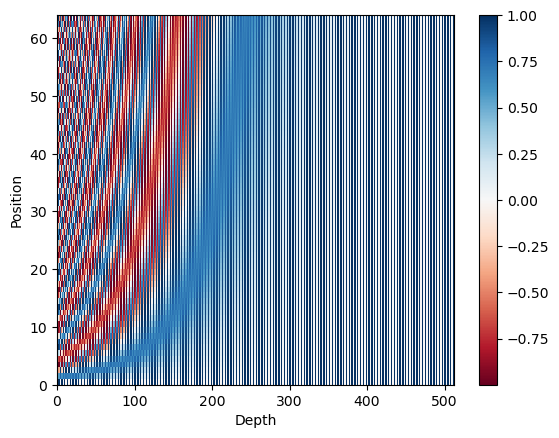

In [135]:
print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, embed_dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [151]:
input_embs.shape

torch.Size([10, 33, 512])

In [152]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True) # pos_encoding을 embedding layer처럼 사용 (gradient 학습 X)
# tensor로 취급하고 requires_grad=False로 해도 된다.

# 1 ... len
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = (inputs == 0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)

input_sums = input_embs + pos_embs

(453, 587, 4)


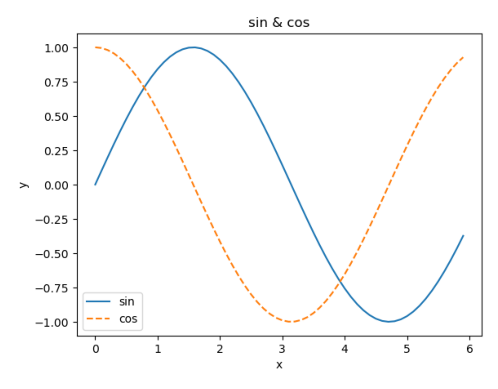

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('output.png') # 이미지 파일을 읽어서 numpy array 형태로 저장
print(img.shape)

plt.imshow(img) 

# numpy array 형식의 데이터로도 출력 가능!
# img_array = np.random.randint(0, 256, size=(3, 3))
# plt.imshow(img_array)
plt.axis('off') # 축 눈금 제거
plt.show()

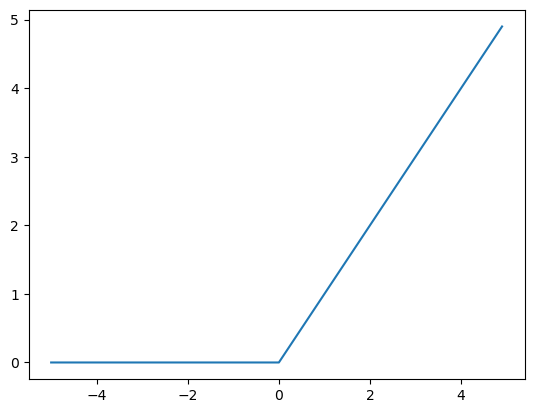

In [88]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x) # element-wise maximum

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)
# plt.ylim(-0.1, 1.1)
plt.show()

In [89]:
A = np.array([1,2,3])
B = np.array([4,5,6])
A.dot(B)

32

In [90]:
X = np.array([1, 2])
W = np.array([[1,3,5],[2,4,6]])
Y = np.dot(X, W)
Y

array([ 5, 11, 17])